## K-nearest neighbors classifier

In [1]:
import numpy as np
import pandas as pd

with np.load('cifar4-train.npz', allow_pickle = False) as npz_file:
    cifar4_data = dict(npz_file.items())
    
print(list(cifar4_data.keys()))

['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']


In [2]:
# Load data 

X = cifar4_data['overfeat']
y = cifar4_data['labels']
names = cifar4_data['names']

print('X:', X.shape, X.dtype)
print('y:', y.shape, y.dtype)
print('names:', names)


X: (5000, 4096) float32
y: (5000,) int64
names: ['truck' 'car' 'airplane' 'ship']


In [3]:
from sklearn.model_selection import train_test_split

# Convert the type of the input matrix to float
X = X.astype(np.float32)


# Split data into train/test sets keeping same proportion of classes

X_tr, X_te, y_tr, y_te, X_pix_tr, X_pix_te  = train_test_split(
    X, y, cifar4_data['pixels'], train_size=4000, test_size=1000, random_state=0, stratify = y)

print('Train set:', X_tr.shape, y_tr.shape)
print('Test set', X_te.shape, y_te.shape)
print('Pixel set', X_pix_tr.shape, X_pix_te.shape)

Train set: (4000, 4096) (4000,)
Test set (1000, 4096) (1000,)
Pixel set (4000, 3072) (1000, 3072)


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid


#Create a Pipeline with PCA and KNeighborsClassifier steps

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=165)), #Set number of components to retain 90% of the variance, it is 165
    ('knn', KNeighborsClassifier(algorithm='brute', n_jobs=-1))
])

pipe.fit(X_tr, y_tr)
accuracy = pipe.score(X_te, y_te)
print('Accuracy:', accuracy)

Accuracy: 0.756


In [5]:
# Split train set into train/validation sets, keeping same proportion of classes
X_tr_s, X_val, y_tr_s, y_val = train_test_split(X_tr, y_tr, train_size=3200, test_size=800, random_state=0, stratify = y_tr)

print('Small train set:', X_tr_s.shape, y_tr_s.shape)
print('Validation set:', X_val.shape, y_val.shape)

Small train set: (3200, 4096) (3200,)
Validation set: (800, 4096) (800,)


In [10]:
#Tune k and distance metric using grid search
grid = ParameterGrid({
    'knn__n_neighbors': [10, 15, 20, 25, 30, 35, 40, 50, 70, 100], 
    'knn__p': [1, 2], 
})

print('Number of combinations:', len(grid))

Number of combinations: 20


In [11]:
# Save accuracy on validation set
validation_scores = []

for i, params_dict in enumerate(grid, 1):
    print('Combination {}/{}'.format(
        i, len(grid) 
    ))
        
    pipe.set_params(**params_dict)
    pipe.fit(X_tr_s, y_tr_s)
    params_dict['accuracy'] = pipe.score(X_val, y_val)
    validation_scores.append(params_dict)

print('done')

Combination 1/20
Combination 2/20
Combination 3/20
Combination 4/20
Combination 5/20
Combination 6/20
Combination 7/20
Combination 8/20
Combination 9/20
Combination 10/20
Combination 11/20
Combination 12/20
Combination 13/20
Combination 14/20
Combination 15/20
Combination 16/20
Combination 17/20
Combination 18/20
Combination 19/20
Combination 20/20
done


In [12]:
# Create DataFrame with test scores
scores_df = pd.DataFrame(validation_scores)

# Print scores
scores_df.sort_values(by='accuracy', ascending=False)

,accuracy,knn__n_neighbors,knn__p
11,0.77750,35,2
15,0.77250,50,2
7,0.77250,25,2
17,0.77125,70,2
9,0.77125,30,2
8,0.76875,30,1
13,0.76875,40,2
2,0.76625,15,1
5,0.76625,20,2
12,0.76500,40,1


In [13]:
#Find the combination with the best validation accuracy and print it
idx = np.argmax(scores_df.accuracy)
top_accuracy = scores_df.accuracy[idx]
k = scores_df.knn__n_neighbors[idx]
d = scores_df.knn__p[idx]
print('Top_accuracy on validation set: {:.2f} with k={} and distance metric={}'.format(top_accuracy, k, d))


Top_accuracy on validation set: 0.78 with k=35 and distance metric=2


C:\Users\User1\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [14]:
#fit k-NN classifier with tuned parameters to the entire train data set with 4000 data points
#evaluate its accuracy on the test set

pipe.set_params(knn__n_neighbors=35, knn__p=2)
pipe.fit(X_tr, y_tr)
accuracy=pipe.score(X_te,y_te)
print('k_NN Accuracy test set:', accuracy)

k_NN Accuracy test set: 0.781


#### For the second task, pick a test image and plot it with its 10 nearest neighbors from the train set.

In [15]:
#Extract the PCA transformer and the  KNeighborsClassifier estimator from your pipeline.
#Apply PCA to your test image and pass the result to the kneighbors(X, n_neighbors) function of your k-NN estimator. 

scaler = StandardScaler()
X_tr_stand = scaler.fit_transform(X_tr)
X_te_stand = scaler.fit_transform(X_te)

#Pick an image from test set. Reshape it
img = X_te_stand[11]
img_new = img.reshape(1, -1)

pca = PCA(n_components=165)
pca.fit(X_tr_stand, y=None)

X_tr_reduced = pca.transform(X_tr_stand)
X_te_reduced = pca.transform(X_te_stand)

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_tr_reduced, y_tr)

X_img = pca.transform(img_new)
distances, indices = knn.kneighbors(X_img, n_neighbors=10, return_distance=True)

In [16]:
distances, indices

(array([[60.48176328, 60.48888818, 60.5389622 , 61.1667621 , 61.46218343,
         61.55481817, 61.9080836 , 61.94690905, 62.55388842, 62.56714033]]),
 array([[3313,  400,  157,  320, 3841, 1151, 1703, 2274, 2014,    3]],
       dtype=int64))

In [17]:
img_set = X_pix_tr[indices[0]]
img_set.shape

(10, 3072)

In [18]:
indices[0]

array([3313,  400,  157,  320, 3841, 1151, 1703, 2274, 2014,    3],
      dtype=int64)

In [19]:
distances[0]

array([60.48176328, 60.48888818, 60.5389622 , 61.1667621 , 61.46218343,
       61.55481817, 61.9080836 , 61.94690905, 62.55388842, 62.56714033])

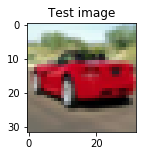

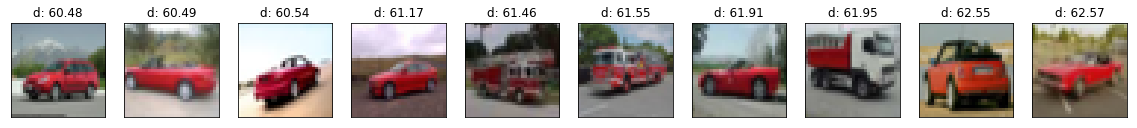

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

test_img_flat = X_pix_te[11]
test_img = test_img_flat.reshape(32,32,3)
plt.figure(figsize=(2,2))
plt.imshow(test_img)
plt.title('Test image')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,5))


for i, axis in enumerate(axes):
    flat_img=img_set[i]
    img_fin=flat_img.reshape(32,32,3)
    
    axis.set_title('d: {:.2f}'.format(distances[0][i]))
    axis.imshow(img_fin)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    

plt.show()